Gray Level Co-occurrence Matrix (GLCM) is used for texture analysis.
We consider two pixels at a time, called the reference and the neighbour pixel.
We define a particular spatial relationship between the reference and neighbour
pixel before calculating the GLCM. For eg, we may define the neighbour to be 1
pixel to the right of the current pixel, or it can be 3 pixels above, or 2 pixels
diagonally (one of NE, NW, SE, SW) from the reference.

Once a spatial relationship is defined, we create a GLCM of size (Range of
Intensities x Range of Intensities) all initialised to 0. For eg, a 8 bit single
channel Image will have a 256x256 GLCM. We then traverse through the image and for
every pair of intensities we find for the defined spatial relationship, we increment
that cell of the matrix.

## Gray Level Co-occurence Matrix

Each entry of the GLCM[i,j] holds the count of the number of times that pair of
intensities appears in the image with the defined spatial relationship.

![](assets/glcm.png)

The matrix may be made symmetrical by adding it to its transpose and normalised to
that each cell expresses the probability of that pair of intensities occurring in the image.

Once the GLCM is calculated, we can find texture properties from the matrix to represent
the textures in the image.

## GLCM Properties

The properties can be calculated over the entire matrix or by considering a window
which is moved along the matrix.

- Mean
- Variance
- Correlation
- Contrast
- IDM (Inverse Difference Moment)
- ASM (Angular Second Moment)
- Entropy
- Max Probability
- Energy
- Dissimilarity

ImageFeatures.jl provide methods for GLCM matrix calculation(with symmetric and normalized versions)

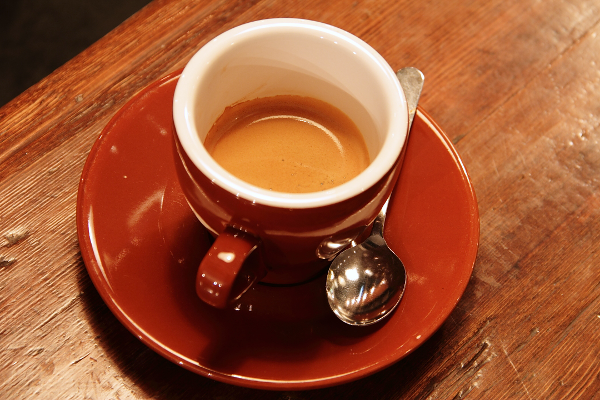

In [1]:
using Images, TestImages
using ImageFeatures

img_src = testimage("coffee")

In this section, we will see how glcm could be calculated and how results are
different for different types of textures. We will be using 4 `10x10` pixels
patches as shown below.

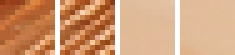

In [2]:
img_patch1 = img_src[170:180, 20:30] # Patch 1 & Patch 2 are from table with unidirectional texture
img_patch2 = img_src[190:200, 20:30]
img_patch3 = img_src[40:50, 310:320] # Patch 3 & Patch 4 are from coffe inside cup
img_patch4 = img_src[60:70, 320:330]
img_patches = [img_patch1, img_patch2, img_patch3, img_patch4]
mosaicview(img_patches; nrow=1, npad=1, fillvalue=1)

As we can already take a guess, patch 1 and patch 2 are very similiar(unidirectional texture) and
that's also true for patch 3 and patch 4 which are very similiar(smooth texture).

In [3]:
glcm_results = [];
glcm_sym_results = [];
glcm_norm_results = [];

The `distances` and `angles` arguments may be a single integer or a vector of
integers if multiple GLCMs need to be calculated. The `mat_size` argument is used
to define the granularity of the GLCM.

In [4]:
distance = 5
angle = 0
mat_size = 4

for patch in img_patches
    glcm_output = glcm(patch, distance, angle, mat_size)
    glcm_sym_output = glcm_symmetric(patch, distance, angle, mat_size)
    glcm_norm_output = glcm_norm(patch, distance, angle, mat_size)
    push!(glcm_results, glcm_output)
    push!(glcm_sym_results, glcm_sym_output)
    push!(glcm_norm_results, glcm_norm_output)
end

glcm_results # GLCM matrix

4-element Vector{Any}:
 [0 0 0 0; 0 19 21 0; 0 10 13 3; 0 0 0 0]
 [0 0 0 0; 0 26 7 0; 0 7 11 9; 0 0 6 0]
 [0 0 0 0; 0 0 0 0; 0 0 0 0; 0 0 0 66]
 [0 0 0 0; 0 0 0 0; 0 0 0 8; 0 0 0 58]

GLCM symmetrical is basically `glcm_output .+ transpose(glcm_output)`

In [5]:
glcm_sym_results # GLCM Symmetrical matrix

4-element Vector{Any}:
 [0 0 0 0; 0 38 31 0; 0 31 26 3; 0 0 3 0]
 [0 0 0 0; 0 52 14 0; 0 14 22 15; 0 0 15 0]
 [0 0 0 0; 0 0 0 0; 0 0 0 0; 0 0 0 132]
 [0 0 0 0; 0 0 0 0; 0 0 0 8; 0 0 8 116]

GLCM normalised is basically `glcm_output ./ sum(glcm_output)`

In [6]:
glcm_norm_results # GLCM normalised matrix

4-element Vector{Any}:
 [0.0 0.0 0.0 0.0; 0.0 0.2878787878787879 0.3181818181818182 0.0; 0.0 0.15151515151515152 0.19696969696969696 0.045454545454545456; 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0; 0.0 0.3939393939393939 0.10606060606060606 0.0; 0.0 0.10606060606060606 0.16666666666666666 0.13636363636363635; 0.0 0.0 0.09090909090909091 0.0]
 [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 1.0]
 [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.12121212121212122; 0.0 0.0 0.0 0.8787878787878788]

In next part, we will see how the GLCM matrix calculation can be used to
differentiate textures based on statistics. `glcm_prop` is used to calculate
various properties.
Various properties can be calculated like `mean`, `variance`, `correlation`,
`contrast`, `IDM` (Inverse Difference Moment),`ASM` (Angular Second Moment),
`entropy`, `max_prob` (Max Probability), `energy` and `dissimilarity`.

In [7]:
property = [correlation,dissimilarity]
x = []
y = []

for i in glcm_results
    point = []
    for j in property
        glcm_pro = glcm_prop(i, j)
        push!(point,glcm_pro)
    end
    push!(x,point[1])
    push!(y,point[2])
end
x,y

(Any[0.9999911893782694, 0.9999924450485808, 1.0, 0.9999991621219851], Any[34, 29, 0, 8])

These properties can be directly calculated too using syntax `property(glcm_matrix)`.
For example: To calculate correlation, we can do `correlation(glcm(img_patch1))``

We can create graph between correlation and dissimilarity properties of particular
GLCM matrices. It's easy to notice that the Patch 1 & Patch 2 are closer in the properties
and similiarly for Patch 3 and Patch 4.

![](assets/scatter.png)

Graph can be made using GLCM symmetric and normalised version, which produces very similiar outputs to give
us a hint at how similiar textures have similiar properties.

References:
- https://en.wikipedia.org/wiki/Co-occurrence_matrix
- Scikit GLCM example

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*